<a href="https://colab.research.google.com/github/SEBIN6/Ayna_Assignment/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
import os

!unzip -q dataset.zip -d dataset

## Import Libraries and Define Classes

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# Check for a GPU and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Define Unet class

In [4]:
class UNet(nn.Module):
    def __init__(self, input_channels=1, output_channels=3):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        # Encoder path
        self.enc1 = conv_block(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)

        # Process the color vector
        self.color_fc = nn.Linear(3, 256 * 64 * 64)
        self.bn_color = nn.BatchNorm2d(256)

        # Decoder path
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)

        # Final output layer
        self.final = nn.Conv2d(64, output_channels, 1)

    def forward(self, x, color):
        B, _, H, W = x.shape

        # Encoder forward pass
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        # Process the color vector and combine with bottleneck features
        color_features = self.color_fc(color)
        color_features = color_features.view(B, 256, 64, 64)
        e3_combined = e3 + color_features

        # Decoder forward pass with skip connections
        d1 = self.up1(e3_combined)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)

        return self.final(d2)

## Define Utility Functions

In [5]:
def prepare_input(image_path, color_name, transform):
    color_map = {
        "red": [1, 0, 0],
        "green": [0, 1, 0],
        "blue": [0, 0, 1],
        "yellow": [1, 1, 0],
        "cyan": [0, 1, 1],
        "magenta": [1, 0, 1],
        "black": [0, 0, 0],
        "white": [1, 1, 1],
        "orange": [1, 0.5, 0],
        "purple": [0.5, 0, 0.5],
    }

    input_img = Image.open(image_path).convert("L")
    input_tensor = transform(input_img).unsqueeze(0).to(device)

    # Get the color vector
    color_key = color_name.lower()
    if color_key not in color_map:
        print(f"Warning: color '{color_name}' not in map, defaulting to black")
        color_vector = torch.tensor(color_map["black"], dtype=torch.float32)
    else:
        color_vector = torch.tensor(color_map[color_key], dtype=torch.float32)
    color_vector = color_vector.unsqueeze(0).to(device)
    return input_tensor, color_vector

# Helper function to visualize the results
def visualize_output(input_tensor, output_tensor):
    input_image = input_tensor.squeeze().cpu().numpy()
    output_image = output_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy()

    # Clip values to be in the [0, 1] range for proper display
    output_image = np.clip(output_image, 0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(input_image, cmap='gray')
    axes[0].set_title('Input Polygon (Grayscale)')
    axes[0].axis('off')

    axes[1].imshow(output_image)
    axes[1].set_title('Generated Output (Color)')
    axes[1].axis('off')

    plt.show()

## Load The Model

In [7]:
model = UNet().to(device)
model_path = "unet_model.pth"

# Load the weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print("Model loaded successfully and set to evaluation mode.")

Model loaded successfully and set to evaluation mode.


## Infrence Function

In [8]:
def run_inference(image_path, color_name):

    # Define the same transformation used during training
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])

    # Prepare the input tensors
    input_tensor, color_vector = prepare_input(image_path, color_name, transform)

    # Run the model in inference mode
    with torch.no_grad():
        output_tensor = model(input_tensor, color_vector)

    print(f"Inference complete for {image_path} with color '{color_name}'.")

    # Visualize the results
    visualize_output(input_tensor, output_tensor)

Inference complete for /content/dataset/dataset/validation/inputs/square.png with color 'magenta'.


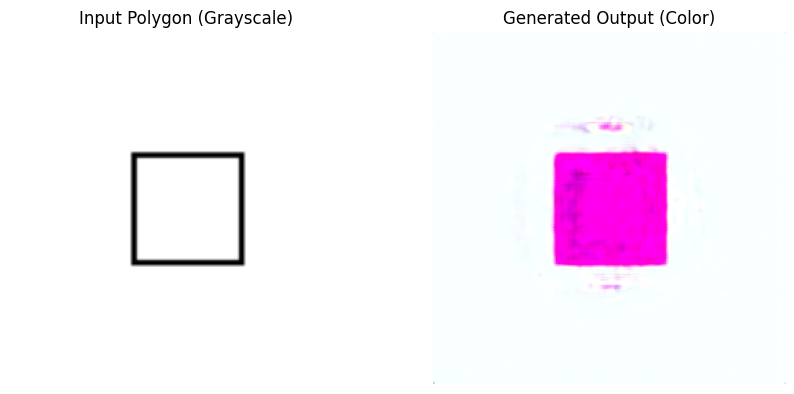

In [10]:
# Example Usage


test_image_path = "/content/dataset/dataset/validation/inputs/square.png"
desired_color = "magenta"

# Run the inference
run_inference(test_image_path, desired_color)
